In [1]:
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def import_ac_data(folder: str, ACUnit: str):
    """
    Import AC data from a .AC file.

    Each block in the file has the layout:
      • t0    : float64
      • f_d   : float64
      • dc    : float64 (NaN → 0)
      • n     : uint8   (number of Fourier coefficient pairs)
      • 2*n float64s: real1, imag1, real2, imag2, … real_n, imag_n

    We pack each set into a (4 × 24) matrix:
      row 0 = [dc,    AC_real(1)…AC_real(23)]
      row 1 = [0,     AC_imag(1)…AC_imag(23)]
      row 2 = [0,    f_d, 2f_d … 23f_d]
      row 3 = [t0,    0…0]

    Returns:
      AC_coeffs       : np.ndarray, shape (4,24,num_sets)
      voltage_sample_at : function(t: float, coeffs) → float
      voltage_vec       : function(t_array: np.ndarray, coeffs) → np.ndarray
    """
    path = os.path.join(folder, f"{ACUnit}.AC")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    coeffs_list = []
    with open(path, 'rb') as f:
        while True:
            # read t0, f_d, dc, n
            header = f.read(8*3 + 1)
            if len(header) < 8*3 + 1:
                break
            t0, f_d, dc = struct.unpack('<ddd', header[:24])
            n = struct.unpack('<B', header[24:25])[0]

            # fix dc NaN
            if np.isnan(dc):
                dc = 0.0

            if n == 0:
                continue

            # read 2*n float64s (real/imag pairs)
            data_bytes = f.read(8 * 2 * n)
            if len(data_bytes) < 8*2*n:
                break
            vals = np.frombuffer(data_bytes, dtype='<f8')
            real = vals[0::2]
            imag = vals[1::2]

            # pad or truncate to 23 coefficients
            if real.size < 23:
                real = np.pad(real, (0, 23 - real.size))
            else:
                real = real[:23]
            if imag.size < 23:
                imag = np.pad(imag, (0, 23 - imag.size))
            else:
                imag = imag[:23]

            # build the 4×24 block
            real_row = np.concatenate(([dc], real))
            imag_row = np.concatenate(([0.0], imag))
            freq_row = np.concatenate(([0.0], np.arange(1, 24) * f_d))
            time_row = np.concatenate(([t0], np.zeros(23)))

            block = np.vstack([real_row, imag_row, freq_row, time_row])
            coeffs_list.append(block)

    if not coeffs_list:
        # no data found
        AC_coeffs = np.empty((4, 24, 0))
    else:
        AC_coeffs = np.stack(coeffs_list, axis=2)

    # helper functions
    def voltage_sample_at(t: float, coeffs: np.ndarray) -> float:
        # pick the latest set whose t0 < t
        t0s = coeffs[3, 0, :]
        idx = np.where(t0s < t)[0]
        i = idx.max() if idx.size else coeffs.shape[2] - 1
        r = coeffs[0, :, i]
        im = coeffs[1, :, i]
        f = coeffs[2, :, i]
        dt = t - coeffs[3, 0, i]
        return np.sum(r * np.cos(2 * np.pi * f * dt) - im * np.sin(2 * np.pi * f * dt))

    def voltage_vec(t_arr: np.ndarray, coeffs: np.ndarray) -> np.ndarray:
        # reconstruct over a vector of times
        return np.array([voltage_sample_at(t, coeffs) for t in t_arr])

    return AC_coeffs, voltage_sample_at, voltage_vec


In [2]:
# Ask the user for a path (e.g. C:\Users\you\Documents\report.pdf)
filepath_str = input("Enter the full file path: ").strip().strip('"')

# Convert the string to a Path object
filepath = Path(filepath_str)

# Extract the directory (parent) and the file name separately
folder   = filepath.parent          # PosixPath or WindowsPath object
filename = filepath.name            # Just the file’s name with extension

print(f"Folder : {folder}")
print(f"Filename: {filename}")

AC_coeffs, sample_fn, vec_fn = import_ac_data(folder, filename.removesuffix('.AC'))

# single time
v_at_1s = sample_fn(1.234, AC_coeffs)

# vector of times
t = np.linspace(0, 10, 1001)
v = vec_fn(t, AC_coeffs)

# Print the overall shape: (4, 24, N_blocks)
print("AC_coeffs shape:", AC_coeffs.shape)

# Peek at the first block of 4×24 coefficients
print("First coefficient set (block 0):\n", AC_coeffs[:, :, 0])

# take block k = 0 (for example)
block0 = AC_coeffs[:, :, 0].T   # shape (24,4) so each row is one coefficient
df = pd.DataFrame(block0,
                  columns=["Real", "Imag", "Freq", "t0"],
                  index=[f"Coeff {i}" for i in range(24)])
display(df)

Folder : C:\Users\sapierso\Box\PD-Acoustic Project Data\3rd Party Export (MATLAB)\20250512_11h13m42s
Filename: MPD 800 2.1.1-20250416_12h33m10s365ms.AC
AC_coeffs shape: (4, 24, 166)
First coefficient set (block 0):
 [[ 0.00000000e+00 -1.79582762e+02  1.00930226e+00  7.68952785e-03
  -3.06461805e-02  4.88856040e+00  5.58664944e-02  3.66819566e-01
   2.21136406e-02  4.14489449e-01  1.52265913e-02  1.07984326e+00
   3.29901876e-02  7.68386227e-01 -1.02236630e-02  2.94970566e-03
   4.71147838e-03 -2.29303734e-01  9.31586197e-03  2.64359444e-01
  -1.10403647e-02  1.04975950e-01  5.30632515e-03  4.14711326e-01]
 [ 0.00000000e+00  4.65159522e+02  1.37887588e+00  3.28260668e+00
  -2.43199076e-01 -1.55401809e+00  1.95692445e-01  2.14041073e+00
   3.61566888e-03  1.73504675e-01  1.23535813e-02  2.68481720e-01
  -1.81600420e-02 -2.83061358e-01  4.47648365e-03 -2.09027261e-01
   4.47285688e-03 -2.47661312e-01 -1.77747122e-02  4.87852547e-01
   4.32410309e-03  1.16533146e-01  4.38199970e-03 -7.0589

,Real,Imag,Freq,t0
Coeff 0,0.000000,0.000000,0.000000,0.684848
Coeff 1,-179.582762,465.159522,60.019472,0.000000
Coeff 2,1.009302,1.378876,120.038943,0.000000
Coeff 3,0.007690,3.282607,180.058415,0.000000
Coeff 4,-0.030646,-0.243199,240.077887,0.000000
Coeff 5,4.888560,-1.554018,300.097358,0.000000
Coeff 6,0.055866,0.195692,360.116830,0.000000
Coeff 7,0.366820,2.140411,420.136302,0.000000
Coeff 8,0.022114,0.003616,480.155773,0.000000
Coeff 9,0.414489,0.173505,540.175245,0.000000


t0_min: 0.6848479942500001, t0_max: 50.01055999425
RMS voltage = 912.127 V
AC‑only RMS voltage = 912.127 V


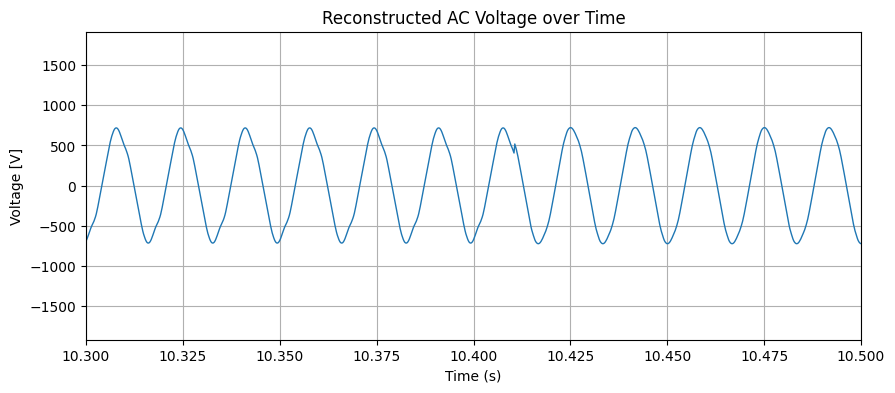

In [3]:
# make a time vector (e.g. from the first t0 up to last + 1s)
t0_min = AC_coeffs[3,0,0]
t0_max = AC_coeffs[3,0,-1]
print(f"t0_min: {t0_min}, t0_max: {t0_max}")

fs = 5000
t = np.arange(t0_min, t0_max + 1.0, 1/fs)

# compute the voltage trace
v = vec_fn(t, AC_coeffs)

# simple RMS (includes any DC offset)
rms = np.sqrt(np.mean(v**2))
print(f"RMS voltage = {rms:.3f} V")

# removed the DC offset from AC RMS
v_ac = v - np.mean(v)
rms_ac = np.sqrt(np.mean(v_ac**2))
print(f"AC‑only RMS voltage = {rms_ac:.3f} V")

# plot it
plt.figure(figsize=(10,4))
plt.plot(t, v, lw=1)
plt.xlim(10.3, 10.5)
plt.xlabel("Time (s)")
plt.ylabel("Voltage [V]")
plt.title("Reconstructed AC Voltage over Time")
plt.grid(True)
plt.show()

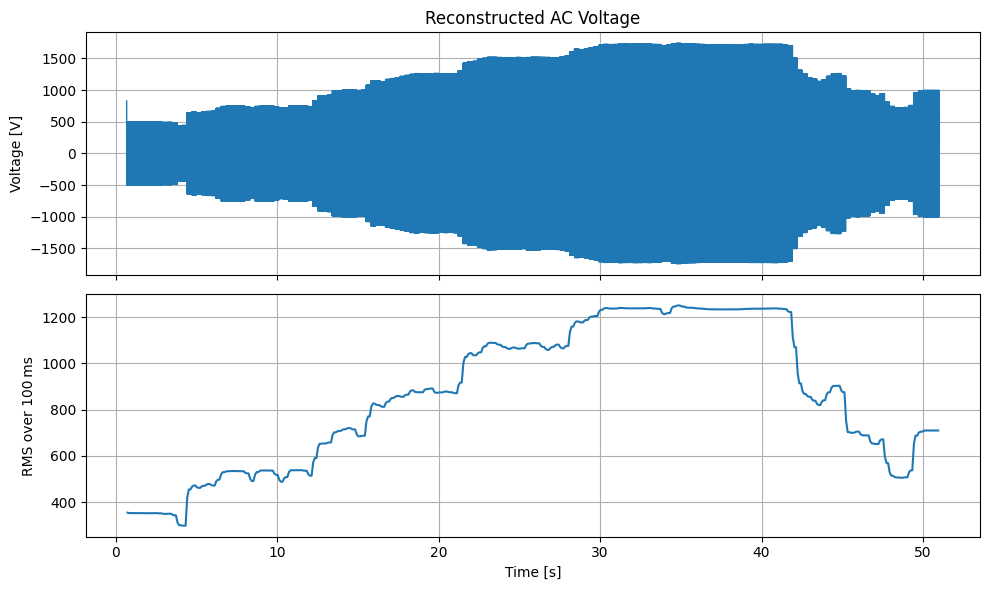

In [4]:
# — parameters — 
fs = 5000               # sampling rate you used with arange()
window_ms = 100         # size of each RMS window in milliseconds
win_samples = int(window_ms/1000 * fs)

# assume you already have:
#   t : 1‑D time array
#   v : 1‑D voltage array (same length as t)

# trim off the tail so we have an integer number of windows
n_full = len(v) // win_samples
v_trim = v[:n_full * win_samples]
t_trim = t[:n_full * win_samples]

# reshape into (n_windows, win_samples)
v_w = v_trim.reshape(n_full, win_samples)
t_w = t_trim.reshape(n_full, win_samples)

# compute RMS per window
rms = np.sqrt(np.mean(v_w**2, axis=1))

# compute a time for each window, e.g. the center
t_rms = t_w.mean(axis=1)

# — plotting —
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1) reconstructed waveform
ax1.plot(t, v, lw=1)
ax1.set(title="Reconstructed AC Voltage", ylabel="Voltage [V]")
ax1.grid(True)

# 2) windowed RMS
ax2.plot(t_rms, rms, linestyle='-')
ax2.set(xlabel="Time [s]", ylabel=f"RMS over {window_ms} ms")
ax2.grid(True)

plt.tight_layout()
plt.show()